In [2]:
import pysm3
import pysm3.units as u
import astropy.io.fits as fits
import reproject as rp

import healpy as hp
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_noise_realization, get_instrument, get_sky)
from fgbuster.visualization import corner_norm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Sky - pysm

Nei notebook scritti fino ad ora, i pixel avevano size = 0.5 arcmin. Purtroppo in pysm la mappa viene creata sempre delle stesse dimensioni, si può solo scegliere il numero di pixel (dato da $12 nside^2$). Di conseguenza la size dei pixel dipende da quanti pixel ho. Con nside = 128 vengono grandi 27 arcmin, e tutta l'analisi delle mappe viene male perchè sono troppo grandi. Per avere una size simile a 0.5 arcmin, serve nside = 4096

In [2]:
nside = 4096

#Give pixel area given nside in square radians or square degrees.
pix_area_deg = hp.pixelfunc.nside2pixarea(4096, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin")

With nside = 4096, the pixel size is 0.8588716029543514 arcmin


In [5]:
# pysm sky
sky = pysm3.Sky(nside=4096, preset_strings=["d1", "s1"])

## Sky - fgbuster

Per fare la component separation alla fine mi serve un elemento di fgbuster del tipo (n_frequency, 3, n_pix), ma per trasformare le mappe da 1d a 2d per fare l'analisi mi serve un elemento di pysm del tipo (n_pix). Quindi creo il cielo con fgbuster, ma dallo strumento prendo solo una frequenza (in questo caso 100 GHz) in modo da avere un elemento (1, 3, n_pix), dove 3 rappresenta I, Q, U. In questo modo posso lavorare singolarmente su array 1d I, Q, U e alla fine posso riunirli facilmente in un elemento (1, 3, n_pix) per fare la component separation. 

In [9]:
# convert to fgbuster sky

#instrument = get_instrument('LiteBIRD')

#df   = pd.DataFrame(instrument)
#freq = df.iloc[2:8, :]            #estraggo solo la frequenza 100 Ghz dallo strumento

#freq
#instrument

In [16]:
instrument = get_instrument('LiteBIRD')

sky_fgb    = get_observation(instrument, sky , nside=4096,noise=False, unit='uK_CMB')
print(np.shape(sky_fgb))

(15, 3, 201326592)


In [17]:
# seleziono solo alcune frequenze (8 su 15) altrimenti ci mette tantissimo
mappa40  = sky_fgb[0, :, :]
mappa60  = sky_fgb[2, :, :]
mappa68  = sky_fgb[3, :, :]
mappa78  = sky_fgb[4, :, :]
mappa89  = sky_fgb[5, :, :]
mappa100 = sky_fgb[6, :, :]
mappa119 = sky_fgb[7, :, :]
mappa140 = sky_fgb[8, :, :]


np.shape(mappa60)

(3, 201326592)

In [18]:
I_map40 = mappa40[0,:]
Q_map40 = mappa40[1,:]
U_map40 = mappa40[2,:]

I_map60 = mappa60[0,:]
Q_map60 = mappa60[1,:]
U_map60 = mappa60[2,:]

I_map68 = mappa68[0,:]
Q_map68 = mappa68[1,:]
U_map68 = mappa68[2,:]

I_map78 = mappa78[0,:]
Q_map78 = mappa78[1,:]
U_map78 = mappa78[2,:]

I_map89 = mappa89[0,:]
Q_map89 = mappa89[1,:]
U_map89 = mappa89[2,:]

I_map100 = mappa100[0,:]
Q_map100 = mappa100[1,:]
U_map100 = mappa100[2,:]

I_map119 = mappa119[0,:]
Q_map119 = mappa119[1,:]
U_map119 = mappa119[2,:]

I_map140 = mappa140[0,:]
Q_map140 = mappa140[1,:]
U_map140 = mappa140[2,:]

np.shape(I_map60)

(201326592,)

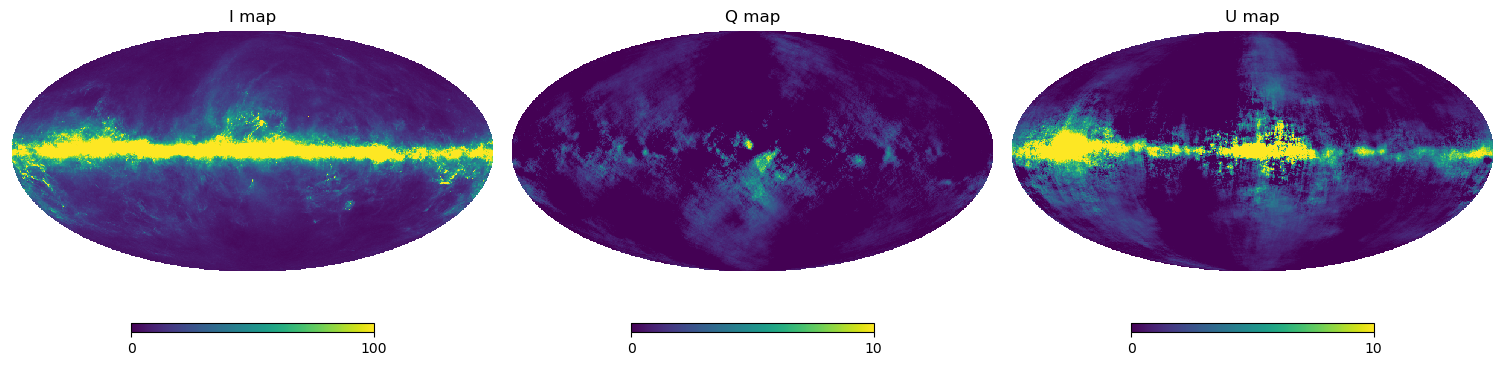

In [19]:
plt.figure(figsize=(15, 10))
hp.mollview(I_map60, min=0, max=1e2, title="I map", sub=(1, 3, 1))
hp.mollview(U_map60, min=0, max=1e1, title="Q map", sub=(1, 3, 2))
hp.mollview(Q_map60, min=0, max=1e1, title="U map", sub=(1, 3, 3))

# Create patch 1D

In [20]:
def create_patch(RA1, RA2, dec1, dec2, nside, map):
    " cambiando il numero di nsdie bisognerà fare un primo test per definire il radius in vec in modo da avere una patch di area circa 10x10 deg e la lengh_patch in base alla len(patch_circle)"
    
    # coordinate della parte di cielo osservata da bicep
    theta1 = np.deg2rad(RA1)
    theta2 = np.deg2rad(RA2)

    phi1   = 0.5 * np.pi - np.deg2rad(dec1) 
    phi2   = 0.5 * np.pi - np.deg2rad(dec2)

    # trovo un punto in mezzo ai 4 vertici in modo da costruirci intorno una patch più piccola
    mid_theta = theta2 + (theta1-theta2)/2
    mid_phi   = phi2 + (phi1-phi2)/2


    # trasformo la lat e lon in indici
    index1 = hp.ang2pix(nside,phi1, theta1)
    index2 = hp.ang2pix(nside, phi2, theta1)
    index3 = hp.ang2pix(nside, phi2, theta2)
    index4 = hp.ang2pix(nside,phi1, theta2) 
    index_mid =  hp.ang2pix(nside,mid_phi, mid_theta) 
    
    
    # creo patch più piccola all'interno dei limiti RA e dec (è circolare e di un numero "sbagliato" di pixel per essere rappresentata con healpy)
    vec = hp.ang2vec(mid_phi, mid_theta)
    ipix_disc = hp.query_disc(nside=4096, vec=vec, radius=np.radians(8))
    patch_circle = map[ipix_disc]
    print("Size patch circolare: ", len(patch_circle))
    
    # all'interno di questa patch ne creo una un po' più piccola con un numero giusto di pixel
    lenght_patch = (260**2)*12
    print("Size patch rettangolare: ", lenght_patch)
    print("Area of the circular patch (deg^2) : " , (pix_size_deg**2) * lenght_patch)
    patch_rect   = patch_circle[int((len(patch_circle) - lenght_patch)/2): int((len(patch_circle) - lenght_patch)/2) + lenght_patch]
    
    return np.array(patch_rect)

In [21]:
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40

In [22]:
# test
patch_test = create_patch(RA1, RA2, dec1, dec2, nside, I_map60)

# la patch è grande 166 deg^2, quindi più di 10x10, ma poi la devo tagliare di nuovo

Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303


In [23]:
patch1d_I40 = create_patch(RA1, RA2, dec1, dec2, nside, I_map40)
patch1d_Q40 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map40)
patch1d_U40 = create_patch(RA1, RA2, dec1, dec2, nside, U_map40)

patch1d_I60 = create_patch(RA1, RA2, dec1, dec2, nside, I_map60)
patch1d_Q60 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map60)
patch1d_U60 = create_patch(RA1, RA2, dec1, dec2, nside, U_map60)

patch1d_I68 = create_patch(RA1, RA2, dec1, dec2, nside, I_map68)
patch1d_Q68 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map68)
patch1d_U68 = create_patch(RA1, RA2, dec1, dec2, nside, U_map68)

patch1d_I78 = create_patch(RA1, RA2, dec1, dec2, nside, I_map78)
patch1d_Q78 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map78)
patch1d_U78 = create_patch(RA1, RA2, dec1, dec2, nside, U_map78)

patch1d_I89 = create_patch(RA1, RA2, dec1, dec2, nside, I_map89)
patch1d_Q89 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map89)
patch1d_U89 = create_patch(RA1, RA2, dec1, dec2, nside, U_map89)

patch1d_I100 = create_patch(RA1, RA2, dec1, dec2, nside, I_map100)
patch1d_Q100 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map100)
patch1d_U100 = create_patch(RA1, RA2, dec1, dec2, nside, U_map100)

patch1d_I119 = create_patch(RA1, RA2, dec1, dec2, nside, I_map119)
patch1d_Q119 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map119)
patch1d_U119 = create_patch(RA1, RA2, dec1, dec2, nside, U_map119)

patch1d_I140 = create_patch(RA1, RA2, dec1, dec2, nside, I_map140)
patch1d_Q140 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map140)
patch1d_U140 = create_patch(RA1, RA2, dec1, dec2, nside, U_map140)

Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the circular patch (deg^2) :  166.2194836414303
Size patch circolare:  979652
Size patch circolare:  811200
Area of the 

In [24]:
fits.writeto("patch1d/patch1d_I40", patch1d_I40, overwrite=True)
fits.writeto("patch1d/patch1d_Q40", patch1d_Q40, overwrite=True)
fits.writeto("patch1d/patch1d_U40", patch1d_U40, overwrite=True)

fits.writeto("patch1d/patch1d_I60", patch1d_I60, overwrite=True)
fits.writeto("patch1d/patch1d_Q60", patch1d_Q60, overwrite=True)
fits.writeto("patch1d/patch1d_U60", patch1d_U60, overwrite=True)

fits.writeto("patch1d/patch1d_I68", patch1d_I68, overwrite=True)
fits.writeto("patch1d/patch1d_Q68", patch1d_Q68, overwrite=True)
fits.writeto("patch1d/patch1d_U68", patch1d_U68, overwrite=True)


fits.writeto("patch1d/patch1d_I78", patch1d_I78, overwrite=True)
fits.writeto("patch1d/patch1d_Q78", patch1d_Q78, overwrite=True)
fits.writeto("patch1d/patch1d_U78", patch1d_U78, overwrite=True)


fits.writeto("patch1d/patch1d_I89", patch1d_I89, overwrite=True)
fits.writeto("patch1d/patch1d_Q89", patch1d_Q89, overwrite=True)
fits.writeto("patch1d/patch1d_U89", patch1d_U89, overwrite=True)


fits.writeto("patch1d/patch1d_I100", patch1d_I100, overwrite=True)
fits.writeto("patch1d/patch1d_Q100", patch1d_Q100, overwrite=True)
fits.writeto("patch1d/patch1d_U100", patch1d_U100, overwrite=True)

fits.writeto("patch1d/patch1d_I119", patch1d_I119, overwrite=True)
fits.writeto("patch1d/patch1d_Q119", patch1d_Q119, overwrite=True)
fits.writeto("patch1d/patch1d_U119", patch1d_U119, overwrite=True)

fits.writeto("patch1d/patch1d_I140", patch1d_I140, overwrite=True)
fits.writeto("patch1d/patch1d_Q140", patch1d_Q140, overwrite=True)
fits.writeto("patch1d/patch1d_U140", patch1d_U140, overwrite=True)

### From galactic to celestial coordinates
https://github.com/aaroncnb/healpix_coordtrans_example/blob/master/hp_coordtrans_example.ipynb

## NB
Passando a mappe 2d la dimensione totale della mappa cambia. Prima era un array 1D lungo 811200, adesso è una mappa 2D di cui posso scegliere la lunghezza delle x mentre le y sono x/2. 
Scelgo x tale che $811200 = Area_{mappa} = x * (\frac{x}{2})$,

Da quello che ho capito è solo una questione di rappresentazione della mappa, ma non voglio che cambi la size dei pixel.

In [25]:
x = np.sqrt(len(patch1d_I60)*2)
int(x)

1273

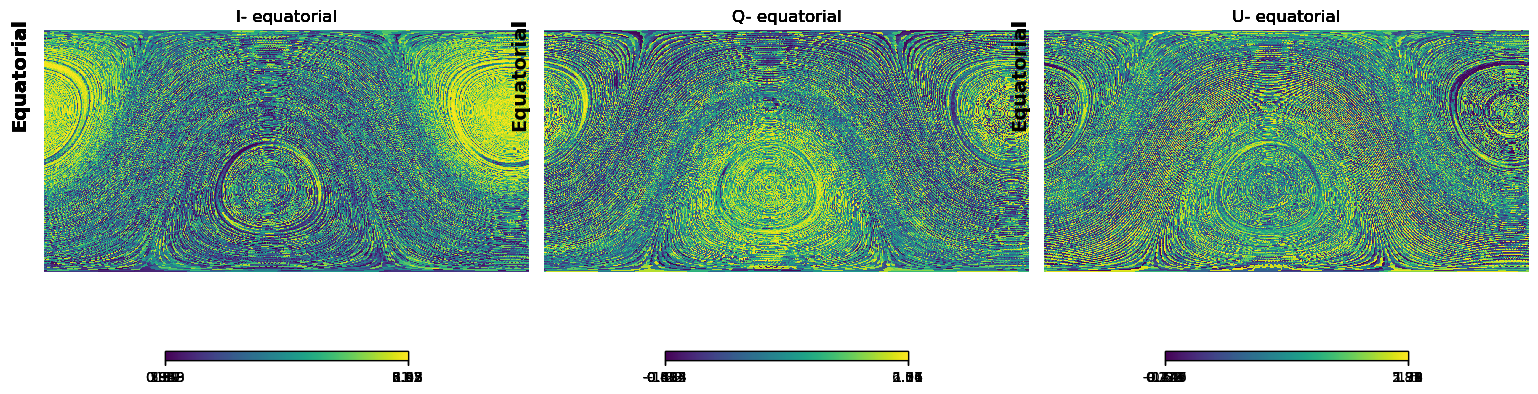

In [36]:
plt.figure(figsize=(15, 10))
patch2d_I40   = hp.cartview(patch1d_I40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q40   = hp.cartview(patch1d_Q40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U40   = hp.cartview(patch1d_U40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


patch2d_I60   = hp.cartview(patch1d_I60, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q60   = hp.cartview(patch1d_Q60, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U60   = hp.cartview(patch1d_U60, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I68   = hp.cartview(patch1d_I68, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q68   = hp.cartview(patch1d_Q68, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U68   = hp.cartview(patch1d_U68, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


patch2d_I78   = hp.cartview(patch1d_I78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q78   = hp.cartview(patch1d_Q78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U78   = hp.cartview(patch1d_U78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


patch2d_I89   = hp.cartview(patch1d_I89, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q89   = hp.cartview(patch1d_Q89, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U89   = hp.cartview(patch1d_U89, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


patch2d_I100  = hp.cartview(patch1d_I100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q100  = hp.cartview(patch1d_Q100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U100  = hp.cartview(patch1d_U100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I119  = hp.cartview(patch1d_I119, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q119  = hp.cartview(patch1d_Q119, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U119  = hp.cartview(patch1d_U119, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I140   = hp.cartview(patch1d_I140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q140   = hp.cartview(patch1d_Q140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U140   = hp.cartview(patch1d_U140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


#Pol_cel = hp.cartview(Pol_map, coord=['G','C'], return_projected_map=True, xsize=800,norm='hist', title="Pol- equatorial", sub=(1, 4, 4))

In [37]:
# quanto è grande un nuovo pixel? 
print(f"Un pixel della mappa 1D gande {len(patch1d_I60)} ha size = {pix_size} arcmin")

# proporzione (non so se serva, cambia poco) 
pix_size = (len(patch2d_I60)*len(patch2d_I60[0])*pix_size)/(len(patch1d_I60)) # proporzione (non so se serva) 
print(f"Un pixel della mappa 1D gande {len(patch2d_I60)*len(patch2d_I60[0])} ha size = {pix_size} arcmin")


Un pixel della mappa 1D gande 811200 ha size = 0.8572072215935967 arcmin
Un pixel della mappa 1D gande 809628 ha size = 0.8555460655872542 arcmin


In [38]:
patch2d_I40 = np.array(patch2d_I40)
patch2d_Q40 = np.array(patch2d_Q40)
patch2d_U40 = np.array(patch2d_U40)

patch2d_I60 = np.array(patch2d_I60)
patch2d_Q60 = np.array(patch2d_Q60)
patch2d_U60 = np.array(patch2d_U60)

patch2d_I68 = np.array(patch2d_I68)
patch2d_Q68 = np.array(patch2d_Q68)
patch2d_U68 = np.array(patch2d_U68)

patch2d_I78 = np.array(patch2d_I78)
patch2d_Q78 = np.array(patch2d_Q78)
patch2d_U78 = np.array(patch2d_U78)

patch2d_I89 = np.array(patch2d_I89)
patch2d_Q89 = np.array(patch2d_Q89)
patch2d_U89 = np.array(patch2d_U89)

patch2d_I100 = np.array(patch2d_I100)
patch2d_Q100 = np.array(patch2d_Q100)
patch2d_U100 = np.array(patch2d_U100)

patch2d_I119 = np.array(patch2d_I119)
patch2d_Q119 = np.array(patch2d_Q119)
patch2d_U119 = np.array(patch2d_U119)

patch2d_I140 = np.array(patch2d_I140)
patch2d_Q140 = np.array(patch2d_Q140)
patch2d_U140 = np.array(patch2d_U140)
#Pol_cel = np.array(Pol_cel)

Le patch hanno cambiato numero di pixel, che non è più un numero rappresentabile con healpy. Le rimpicciolisco ancora un po' in modo che abbiano un numero giusto di pixel 

In [39]:
# le faccio di ...
nside_patch = 200

N_full = 12 *( nside_patch**2)# number of pixels, full map
N_full

480000

In [40]:
# devo trovare un Nx e Ny tali che Nx*Ny = N_full
Ny = 600
Nx = 800

Nx * Ny

480000

In [41]:
pix_size_deg_new = pix_size / 60


X_width = Nx * pix_size_deg
Y_width = Ny * pix_size_deg


# color map
c_min, c_max     = -10, 10      


print(f"Patch con {Nx} x {Ny} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")



Patch con 800 x 600 pixels, ognuno di 0.8555460655872542 arcmin, per una dimensione totale di 11.45 x 8.59 gradi


In [48]:
# creo le nuove patch grandi Nx x Ny 
patch2d_I40 =  np.array(patch2d_I40[0:Ny, 0:Nx])
patch2d_Q40 =  np.array(patch2d_Q40[0:Ny, 0:Nx])
patch2d_U40 =  np.array(patch2d_U40[0:Ny, 0:Nx])

patch2d_I60 =  np.array(patch2d_I60[0:Ny, 0:Nx])
patch2d_Q60 =  np.array(patch2d_Q60[0:Ny, 0:Nx])
patch2d_U60 =  np.array(patch2d_U60[0:Ny, 0:Nx])

patch2d_I68 =  np.array(patch2d_I68[0:Ny, 0:Nx])
patch2d_Q68 =  np.array(patch2d_Q68[0:Ny, 0:Nx])
patch2d_U68 =  np.array(patch2d_U68[0:Ny, 0:Nx])

patch2d_I78 =  np.array(patch2d_I78[0:Ny, 0:Nx])
patch2d_Q78 =  np.array(patch2d_Q78[0:Ny, 0:Nx])
patch2d_U78 =  np.array(patch2d_U78[0:Ny, 0:Nx])

patch2d_I89 =  np.array(patch2d_I89[0:Ny, 0:Nx])
patch2d_Q89 =  np.array(patch2d_Q89[0:Ny, 0:Nx])
patch2d_U89 =  np.array(patch2d_U89[0:Ny, 0:Nx])

patch2d_I100 =  np.array(patch2d_I100[0:Ny, 0:Nx])
patch2d_Q100 =  np.array(patch2d_Q100[0:Ny, 0:Nx])
patch2d_U100 =  np.array(patch2d_U100[0:Ny, 0:Nx])

patch2d_I119 =  np.array(patch2d_I119[0:Ny, 0:Nx])
patch2d_Q119 =  np.array(patch2d_Q119[0:Ny, 0:Nx])
patch2d_U119 =  np.array(patch2d_U119[0:Ny, 0:Nx])

patch2d_I140 =  np.array(patch2d_I140[0:Ny, 0:Nx])
patch2d_Q100 =  np.array(patch2d_Q140[0:Ny, 0:Nx])
patch2d_U140 =  np.array(patch2d_U140[0:Ny, 0:Nx])

### Save the 2d patches

In [49]:

fits.writeto("patch2d/patch2d_I40", patch2d_I40, overwrite=True)
fits.writeto("patch2d/patch2d_Q40", patch2d_Q40, overwrite=True)
fits.writeto("patch2d/patch2d_U40", patch2d_U40, overwrite=True)

fits.writeto("patch2d/patch2d_I60", patch2d_I60, overwrite=True)
fits.writeto("patch2d/patch2d_Q60", patch2d_Q60, overwrite=True)
fits.writeto("patch2d/patch2d_U60", patch2d_U60, overwrite=True)

fits.writeto("patch2d/patch2d_I68", patch2d_I68, overwrite=True)
fits.writeto("patch2d/patch2d_Q68", patch2d_Q68, overwrite=True)
fits.writeto("patch2d/patch2d_U68", patch2d_U68, overwrite=True)


fits.writeto("patch2d/patch2d_I78", patch2d_I78, overwrite=True)
fits.writeto("patch2d/patch2d_Q78", patch2d_Q78, overwrite=True)
fits.writeto("patch2d/patch2d_U78", patch2d_U78, overwrite=True)


fits.writeto("patch2d/patch2d_I89", patch2d_I89, overwrite=True)
fits.writeto("patch2d/patch2d_Q89", patch2d_Q89, overwrite=True)
fits.writeto("patch2d/patch2d_U89", patch2d_U89, overwrite=True)


fits.writeto("patch2d/patch2d_I100", patch2d_I100, overwrite=True)
fits.writeto("patch2d/patch2d_Q100", patch2d_Q100, overwrite=True)
fits.writeto("patch2d/patch2d_U100", patch2d_U100, overwrite=True)

fits.writeto("patch2d/patch2d_I119", patch2d_I119, overwrite=True)
fits.writeto("patch2d/patch2d_Q119", patch2d_Q119, overwrite=True)
fits.writeto("patch2d/patch2d_U119", patch2d_U119, overwrite=True)

fits.writeto("patch2d/patch2d_I140", patch2d_I140, overwrite=True)
fits.writeto("patch2d/patch2d_Q140", patch2d_Q140, overwrite=True)
fits.writeto("patch2d/patch2d_U140", patch2d_U140, overwrite=True)